## ETTh1 Dataset 

date: timestamp 

* OT: Oil temperature "Predictive value "
* Following are six different types of external load features, 
* HUFL: High Use Full Load 
* HULL: High Use Less Load 
* MUFL: Medium Use Full Load  
* MULL: Medium Use Less Load 
* LUFL: Low Use Less Load
* LULL: Low Use Less Load 


### ETTh1: Electricity Transformer dataset, hourly, E Transformer # 1. 

Each E transformer dataset is considered as one TS and 6 Load features are affecting the final predictable “Oil temperature”. 

The dataset is called multivariate but may be not exactly the one we want to look at. It has 6 time series which can impact the target time series. A few cases arise: 
1. each of the 7 TS have to be forecasted. (done for one E transformer)
2. Forecast only 6 TS and use those 6 to predict the Oil temperature. Require development of the model which can be integrated in NP to predict OT using 6 Load features. Not considered for now. 
3. Use OT as the only TS and forecast it, use other 6 TS as exogeneous variables. 

Let's test these in cronological order. 


### Metric for comparison 
I am using MSE for comparison here, but MAE or other metric can be used instead of MSE. 

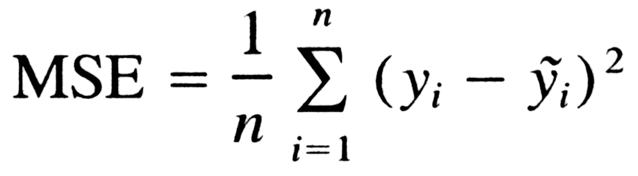

### Conclusions 
#### When considering all the features in the dataset needs to be used for fitting the model. 
1. A set of 7 features are used for fitting the model simultaneous, i.e. they will have same trend, seasonality and AR coefficients. 
2. The fitted value when compared to ground truth (a few values by eye) seems to be a good fit (conclusion last week)
3. However, when using MSE as metric, it is found to be 
### MSE=0.6617

4. Also, the trend is changing for almost each of the value, i.e. size of the input vector and trend is similar. 
5. Trend changing at each timestamp [by definination, monotonically increasing or decreasing] because NP use the last value of the trend from fit and extrapolate it. 
  - This changing trend in the future can be useless for the cases where point of inflection is observed in the forecasting horizion. 
6. However, NP allows each TS to have independent trend (and seasonality), but in that case, only corrrelation between the TS will be using the AR coefficients, 

Let's try that

In [152]:
def MSE(g_truth, measured):
    n=len(g_truth)
    diff=g_truth-measured
    return np.sum(np.square(diff)) / n 
    
    

from sklearn.metrics import mean_absolute_percentage_error
def MAPE(g_truth, measured):
    return (mean_absolute_percentage_error(g_truth,measured))

def wMAPE(g_truth, measured):
    nR = np.sum( np.absolute (g_truth-measured ))
    dR = np.sum( np.absolute (g_truth) )
    return (nR/dR)



### Install dependencies 

In [153]:
#!pip install neuralprophet
#!pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
import torch 
import neuralprophet
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed 
set_log_level("ERROR", "INFO")

import numpy as np
set_random_seed(0)


In [154]:
#!curl https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv > ETTh1.csv
#!curl https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv > ETTh2.csv

### Read dataset 

In [164]:
import pandas as pd

data_location = "ETTh2.csv"
#"https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location )#+ "multivariate/load_ercot_regions.csv")
df_ercot_2 = pd.read_csv('ETTh2.csv')
df_ercot_2.rename({"date":"ds", "OT":"y"},
                 inplace=True,
                axis=1)


df_ercot_2.drop(columns=['HUFL','HULL','MUFL','MULL','LUFL','LULL'],
               inplace=True)

df_ercot.head()

import copy 

df_ercot_copy = copy.deepcopy(df_ercot)

In [165]:
print (len(df_ercot.date), len(df_ercot.date.unique()))
df_ercot[17324:17325]

17420 17420


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
17324,2018-06-22 20:00:00,33.172001,10.722,44.98,11.902,-11.664,-2.612,28.212999


In [166]:
df_init = df_ercot[17324:17325]


### differencing 

In [147]:

df_ercot.HUFL = df_ercot.HUFL.diff()
df_ercot.HULL = df_ercot.HULL.diff()
df_ercot.MUFL = df_ercot.MUFL.diff()
df_ercot.MULL = df_ercot.MULL.diff()
df_ercot.LUFL = df_ercot.LUFL.diff()
df_ercot.LULL = df_ercot.LULL.diff()
df_ercot.OT = df_ercot.OT.diff()
df_ercot=df_ercot.dropna()

In [167]:
regions = list(df_ercot)[1:]
regions

['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

In [168]:
df_global = pd.DataFrame()
for col in regions:
    print (col)
    aux = df_ercot[["date", col]].copy(deep=True)  # select column associated with region
    aux = aux.iloc[:26301, :].copy(deep=True)  # selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns={col: "y"})  # rename column of data to 'y' which is compatible with Neural Prophet
    aux["ID"] = col
    df_global = pd.concat((df_global, aux))


df_global.rename({"date":"ds"},
                 inplace=True,
                axis=1)
df_global

HUFL
HULL
MUFL
MULL
LUFL
LULL
OT


,ds,y,ID
0,2016-07-01 00:00:00,41.130001,HUFL
1,2016-07-01 01:00:00,37.528000,HUFL
2,2016-07-01 02:00:00,37.946999,HUFL
3,2016-07-01 03:00:00,38.952000,HUFL
4,2016-07-01 04:00:00,38.113998,HUFL
...,...,...,...
17415,2018-06-26 15:00:00,47.084999,OT
17416,2018-06-26 16:00:00,48.183498,OT
17417,2018-06-26 17:00:00,48.183498,OT
17418,2018-06-26 18:00:00,46.865501,OT


In [169]:
m = NeuralProphet(n_lags=336)
#df_train, df_test = m.split_df(df_global, valid_p=0.33, local_split=True)
df_train, df_test = m.split_df(df_global, valid_p=0.00551122337, local_split=True)
df_train[df_train.ID=="HUFL"].index[-1] ## index to be saved to reverse differencing 

17325

In [174]:
df_train.shape, df_test.shape,df_global.shape

((121282, 3), (3010, 3), (121940, 3))

In [178]:
121940*.00551122337

672.0385777378

In [177]:
df_test[df_test.ID=='OT']

,ds,y,ID
2580,2018-06-08 22:00:00,35.488499,OT
2581,2018-06-08 23:00:00,35.488499,OT
2582,2018-06-09 00:00:00,35.268501,OT
2583,2018-06-09 01:00:00,34.609501,OT
2584,2018-06-09 02:00:00,33.950001,OT
...,...,...,...
3005,2018-06-26 15:00:00,47.084999,OT
3006,2018-06-26 16:00:00,48.183498,OT
3007,2018-06-26 17:00:00,48.183498,OT
3008,2018-06-26 18:00:00,46.865501,OT


In [179]:
430-336

94

## Case 1: trend = global 

In [161]:
m = NeuralProphet(trend_global_local="global", season_global_local="global", n_lags=336)
metrics = m.fit(df_train, freq='auto')


Finding best initial lr:   0%|          | 0/276 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [162]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

In [163]:
forecast_=forecast[(forecast.ID=="OT")].dropna()
MSE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()), MAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()), wMAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy())

(0.19139924184288307, 0.039036368771985276, 0.037714267825433787)

In [136]:
s=forecast_.yhat1
s=s.append( pd.Series([5.909]), ignore_index=True)
s = s.iloc[-1:].append(s.iloc[:-1], ignore_index=True)
y_exp=s.cumsum()

WARNING - (py.warnings._showwarnmsg) - /var/folders/y_/ckryxn657xd1sjqy61rgk5q80000gn/T/ipykernel_4734/3803420465.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s=s.append( pd.Series([5.909]), ignore_index=True)

WARNING - (py.warnings._showwarnmsg) - /var/folders/y_/ckryxn657xd1sjqy61rgk5q80000gn/T/ipykernel_4734/3803420465.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s = s.iloc[-1:].append(s.iloc[:-1], ignore_index=True)



In [137]:
s[1:10], y_exp[1:10]

(1    6.475523
 2    6.614055
 3    6.355759
 4    5.865170
 5    5.575357
 6    5.612555
 7    5.838531
 8    5.977192
 9    6.441994
 dtype: float64,
 1    12.384523
 2    18.998578
 3    25.354336
 4    31.219506
 5    36.794863
 6    42.407418
 7    48.245949
 8    54.223141
 9    60.665135
 dtype: float64)

In [138]:
y_true=df_ercot_copy[17324:-1].OT

In [139]:
y_true

17324     5.909
17325     5.979
17326     5.839
17327     5.839
17328     5.346
          ...  
17414    10.200
17415    10.904
17416    11.044
17417    10.271
17418     9.778
Name: OT, Length: 95, dtype: float64

In [142]:
MSE(y_exp.to_numpy(), y_true.to_numpy())

194508.810063608

In [141]:
forecast_

,ds,y,ID,yhat1,ar1,trend,season_weekly,season_daily
2922,2018-06-22 22:00:00,5.839,OT,6.475523,10.260613,-3.904886,0.014639,0.105157
2923,2018-06-22 23:00:00,5.839,OT,6.614055,10.267546,-3.904879,0.014140,0.237249
2924,2018-06-23 00:00:00,5.346,OT,6.355759,10.127288,-3.904871,0.013572,0.119771
2925,2018-06-23 01:00:00,5.417,OT,5.865170,9.816777,-3.904864,0.012933,-0.059677
2926,2018-06-23 02:00:00,5.417,OT,5.575357,9.567251,-3.904856,0.012224,-0.099262
...,...,...,...,...,...,...,...,...
3011,2018-06-26 15:00:00,10.904,OT,10.560880,14.410122,-3.904205,-0.079911,0.134874
3012,2018-06-26 16:00:00,11.044,OT,10.949821,14.909025,-3.904198,-0.080114,0.025108
3013,2018-06-26 17:00:00,10.271,OT,10.712383,14.755246,-3.904190,-0.079870,-0.058803
3014,2018-06-26 18:00:00,9.778,OT,10.233411,14.232366,-3.904182,-0.079183,-0.015590


## Case 1.1: same as 1 but removed trend and seasonality; only AR-net 

In [143]:
#m = NeuralProphet(trend_global_local="global", season_global_local="global", n_lags=336)
m = NeuralProphet(growth='off',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  n_lags=336) ## only AR-net 

metrics = m.fit(df_train, freq='auto')
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)
forecast_=forecast[(forecast.ID=="OT")].dropna()
MSE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()), MAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()), wMAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy())


Finding best initial lr:   0%|          | 0/276 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

Predicting: 930it [00:00, ?it/s]

(0.27116900303786534, 0.04555656461889846, 0.04455179688759314)

In [113]:
s=forecast_.yhat1
s=s.append( pd.Series([5.909]), ignore_index=True)
s = s.iloc[-1:].append(s.iloc[:-1], ignore_index=True)
y_exp=s.cumsum()
y_true=df_ercot_copy[17324:-1].OT
MSE(y_exp.to_numpy(), y_true.to_numpy()),


WARNING - (py.warnings._showwarnmsg) - /var/folders/y_/ckryxn657xd1sjqy61rgk5q80000gn/T/ipykernel_4734/1148937045.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s=s.append( pd.Series([5.909]), ignore_index=True)

WARNING - (py.warnings._showwarnmsg) - /var/folders/y_/ckryxn657xd1sjqy61rgk5q80000gn/T/ipykernel_4734/1148937045.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s = s.iloc[-1:].append(s.iloc[:-1], ignore_index=True)



(429.75706935185536,)

In [114]:
s

0     5.909000
1    -0.416388
2    -0.117064
3    -0.289711
4    -0.285194
        ...   
90    0.110573
91    0.060803
92   -0.388416
93   -0.262096
94   -0.611604
Length: 95, dtype: float64

In [115]:
forecast_

,ds,y,ID,yhat1,ar1,trend
2922,2018-06-22 22:00:00,-0.140000,OT,-0.416388,-2.973794,2.557406
2923,2018-06-22 23:00:00,0.000000,OT,-0.117064,-2.674471,2.557406
2924,2018-06-23 00:00:00,-0.493000,OT,-0.289711,-2.847118,2.557406
2925,2018-06-23 01:00:00,0.071000,OT,-0.285194,-2.842601,2.557406
2926,2018-06-23 02:00:00,0.000000,OT,-0.632612,-3.190018,2.557406
...,...,...,...,...,...,...
3011,2018-06-26 15:00:00,0.704000,OT,0.110573,-2.446833,2.557406
3012,2018-06-26 16:00:00,0.139999,OT,0.060803,-2.496602,2.557406
3013,2018-06-26 17:00:00,-0.773000,OT,-0.388416,-2.945823,2.557406
3014,2018-06-26 18:00:00,-0.493000,OT,-0.262096,-2.819503,2.557406


In [116]:
forecast_=forecast.dropna()
MSE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()), MAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()), wMAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy())

(2.6738902037095786, 47723582143866.15, 0.8425857460969356)

In [117]:
fig_param = m.plot_parameters()


AttributeError: 'NoneType' object has no attribute 'global_local'

## Case 2: when trend is independent 


In [60]:
m = NeuralProphet(trend_global_local="local", season_global_local="global", n_lags=24)
metrics = m.fit(df_train, freq='auto')



Finding best initial lr:   0%|          | 0/277 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)


In [ ]:
print ("trend unique values, unique number of trend values, shape of the forecast dataframe")
print (forecast[(forecast.ID=="OT")].dropna().trend.unique())
print (forecast[(forecast.ID=="OT")].dropna().trend.nunique())
print (forecast[(forecast.ID=="OT")].dropna().shape)

In [ ]:
forecast_=forecast[(forecast.ID=="OT")].dropna()
MSE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy())


In [ ]:
forecast_.trend.plot()

In [ ]:
fig_param = m.plot_parameters()


### Case 3: Local seasonality 


In [ ]:
m = NeuralProphet(trend_global_local="local", season_global_local="local", n_lags=24)
metrics = m.fit(df_train, freq='auto')
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)
forecast_=forecast[(forecast.ID=="OT")].dropna()
MSE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy())

## Case 4: Use only Oil temperature, no load features as input. 

In [ ]:
df_ercot.drop(columns=['HUFL','HULL','MUFL','MULL','LUFL','LULL'],
             inplace=True)

In [ ]:
df_ercot.head()

In [ ]:
m_ot = NeuralProphet(n_lags=24)
df_ercot.rename({"date":"ds",
                "OT":"y"},
                 inplace=True,
                axis=1)
df_train_ot, df_test_ot = m_ot.split_df(df_ercot, valid_p=0.33)#, local_split=True)

In [ ]:

m_ot = NeuralProphet(n_lags=24)
metrics = m_ot.fit(df_train_ot, freq='auto')


In [ ]:
future = m_ot.make_future_dataframe(df_test_ot, n_historic_predictions=True)
forecast = m_ot.predict(future)
#forecast_=forecast[(forecast.ID=="OT")].dropna()
MSE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy())

## Case 5: use data for 2 transformer (only OT as time series) 
### prepare dataset for multiple transformers 


In [ ]:
df_all = pd.DataFrame()
df_ercot["ID"] = "T1"
df_ercot_2["ID"] = "T2"
df_all = pd.concat((df_all, df_ercot))
df_all = pd.concat((df_all, df_ercot_2))
df_all.head()


In [ ]:
df_all.shape, df_ercot.shape, df_ercot_2.shape

In [ ]:
m_2t = NeuralProphet(trend_global_local="global", season_global_local="global", n_lags=24)
df_train_2t, df_test_2t = m_2t.split_df(df_all, valid_p=0.33, local_split=True)

In [ ]:
metrics = m_2t.fit(df_train_2t, freq='auto')
future_2t = m_2t.make_future_dataframe(df_test_2t, n_historic_predictions=True)
forecast = m_2t.predict(future_2t)
forecast_t1 = forecast[(forecast.ID=="T1")].dropna()
forecast_t2 = forecast[(forecast.ID=="T2")].dropna()
forecast_ = forecast.dropna()
MSE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()), MSE(forecast_t1.y.to_numpy(), forecast_t1.yhat1.to_numpy()) , MSE(forecast_t2.y.to_numpy(), forecast_t2.yhat1.to_numpy())


### Case 6: using load as external variables 

In [ ]:
def preparedatacase6(df1, df2):
    df = pd.DataFrame()
    
    df1["ID"] = "T1"
    df2["ID"] = "T2"
    df = pd.concat((df, df1))
    df = pd.concat((df, df2))
    df.head()
    return df



In [ ]:
df_ercot = pd.read_csv('ETTh1.csv' )
df_ercot_2 = pd.read_csv('ETTh2.csv')
df = preparedatacase6(df_ercot,df_ercot_2 )
df.rename({"date":"ds", "OT":"y"},
                 inplace=True,
                axis=1)
df



In [ ]:
m_2t_lr = NeuralProphet(trend_global_local="global", season_global_local="global", n_lags=24)
## 2 time series with lagged regressors 
df_train_2t_lr, df_test_2t_lr = m_2t_lr.split_df(df, valid_p=0.33, local_split=True)


In [ ]:
m_2t_lr = m_2t_lr.add_lagged_regressor(names=['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL'])


In [ ]:
metrics = m_2t_lr.fit(df_train_2t_lr, freq='auto')


In [ ]:
future_2t_lr = m_2t_lr.make_future_dataframe(df_test_2t_lr, n_historic_predictions=True)
forecast = m_2t_lr.predict(future_2t_lr)
forecast_t1 = forecast[(forecast.ID=="T1")].dropna()
forecast_t2 = forecast[(forecast.ID=="T2")].dropna()
forecast_ = forecast.dropna()
MSE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()), MSE(forecast_t1.y.to_numpy(), forecast_t1.yhat1.to_numpy()) , MSE(forecast_t2.y.to_numpy(), forecast_t2.yhat1.to_numpy())



## Result 
| Case #| Case | MSE |  Commment|
|----|--|-----|---------|
|**NeuralProphet based**|
| 1.| Global trend & Global seasonal | 0.661704 |  |
| 2.| local trend & Global seasonal | 0.799272 | recomended to keep same type for trend and seasonal  |
| 3.| local trend & local seasonal | 0.650489| Not much difference w.r.t case 1 |
| 4.| without using Load features, line univariate TS | 0.650489  |Expected, if AR is not in the picture, but AR is activated, so these two should ideally be different  |
| 5.| add all transformers, Multivariate TS |0.55468 | using both transformer to MSE calculation, individual MSE: 0.438, 0.670| 
| 6.| using load features as external variables | 0.59020  | individual MSE: 0.463149, 0.717256 | 
|**Vector Auto Regression**|
| 7.1| Vector Auto Regression (VAR) default dataset | 243 | Forecasted all the TS but MSE calculated using OT only   |  
| 7.2| Vector Auto Regression (VAR) with  d =1  | 1.7 | Forecasted all the TS but MSE calculated using OT only   | 
| 7.3| Vector Auto Regression (VAR) with  d =2  | 1.16 | VAR, require pre-processing   |
| 7.4| Vector Auto Regression (VAR) with  d =3  | 2.60 | VAR, require pre-processing   |
| 7.5| VAR for two transformers, with d = 2,lag=24 (as in NP)  | (0.8316063751104331, 0.62725996261246) | works better when using only OT as input, Load variable are dropped. slighly poor than Neural prophet, not very difficult to use. | 
| 7.6| VAR for two transformers, with d = 2, lag = 168 (as in other VAR cases)  | (0.8298342386285907, 0.5931356355054012) | works better when using only OT as input, Load variable are dropped. slighly poor than Neural prophet, not very difficult to use. | 
| **ARIMA** | 
| 8.| Auto ARIMA  | N/A ; very poor for univariate| only for univariate TS, computing instensive and super slow on first go. |  
|**Vanilla models**|
| 9.| Vanilla Transformer Model  |   |  Driven by Student's implementation  | 
| 10.| Vanilla LSTM Model |   | Driven by Student's implementation | 
|**Linear/DLinear variants** |
| 11.| DLinear | | Conda issues fixed, MSE by running their code is: 0.3840945363 for same dataset |
|**Transformer variants**|
| 12.| FedFormer Model (?)  |   | Driven by 11  | 
| 13.| AutoFormer Model (?)  |   | Driven by 11  | 
| 14.| Informer Model (?)  |   | Driven by 11  | 
| 15.| PyraFormer Model (?)  |   | Driven by 11  | 
| 16.| LogTrans Model (?)  |   | Driven by 11  | 
| 17.| Repeat Model (?)  |   | Driven by 11  | 
| 18.| HFformer (trading)? | | https://arxiv.org/pdf/2302.13850.pdf | 




#### To do next: 
0. Try VAR using higher value of d, and also try to do it using only OT (for two ETTs). **Done**
1. Add all Transformer variant models 
2. Make DLinear work 
3. Identify more datasets, variety in dataset is needed 
4. Find the talk video and read that paper as well. 
5. Read more about informer and DLinear models. 

## March 7 

1. <font color='darkgreen'> Added 7.5 and 7.6 for Vector Auto regression. </font>
   - <font color='green'> In general, so far Neural prophet is better than VAR. </font>
   - <font color='green'> partially expected because NP has trend + seasonality + AR and VAR have only AR. </font>
   - <font color='green'> Will be worth switching off the trend and seasonality in NP and compare with AR. </font>
   
2. <font color='darkgreen'> installation of DLinear framework. </font>
   - <font color='green'> very little detail about the code, no documentation other than **ONE** command to run the code. </font>
   - <font color='green'> Ran for one dataset and output is saved. At the moment work only for one dataset, In debugging phase. </font>
   - <font color='green'> Partially understood the output but still figuring out how to calculate metric (MSE) etc. </font>


#### Next steps (aggresive timeline) 
1. <font color='orange'> Add remaining Transformer models in the table. </font>
2. <font color='orange'> Complete the table with other multivariate datasets.  </font>
3. <font color='orange'> Find optimal hyperparameters for NP and VAR, and may be for other models. [21 March] </font>
4. <font color='orange'> March end: Start thinking about the computational paper.  </font>
    - <font color= 'darkorange'> collect more datasets which can compliment the dataset pool. </font>
    - <font color='darkorange'> add any other existing model which might be interesting.  </font>
    - <font color='darkorange'> Brainstrom about the content of the paper, graphs/plots/tables,</font>
    
#### Uniqueness 
<font color='blue'> What is new in this paper: </font> 
1. <font color='blue'> Extending the comparison with existing paper. </font> 
2. <font color='blue'> Added NP and VAR. </font> 
3. <font color='blue'> Anything else we find new in the mean time</font> 

* create a table: easy to see the characteristics of each dataset,e.g.  # of each TS, heavy seasonal / trend effect or see more datures, and collect a pool of dataset.  
* add more datasets in addition to this, identify and add varaity of datasets. 
* strongly coorelated to low coorelated time series
* short and long and very long horizion forecasting performance 
* in addition to values predict something else XXX. [take truck repair as example]

-- Possible datasets
* large dataset from transfusion process from hospital, 
  - label: IV is programmed wrongly 
  - doeses have mistake or not
  - not very useful due to highly imbalance dataset, not many mistakes. 
* incubadors of infants: propritery data can not be shared. 
* HDD dataset: consider this 
  - MSiA: not predicting for each HDD 
  - e.g. in 24 hrs, will there  be >1/2/5 HDD failures. 
  - they have reading for biometric data, and they predict the human motion [check this dataset with students], [conference paper on Diego web page, time series data and make pred about XXX depression not peer reviewed]: see if this is labelled or not. 




* Arrange code so that is can be run for each of the dataset easily, and can be scaled without any issues. 

* UCI dataset: UC Irvine dataset [ check website] might have few multivariate TS datasets which might be of use, to predict something XXX not next values. 
  
    
* Read and implement Augmented Dickey-Fuller stationary test. 
* New paper on transformers for high frequency trading https://arxiv.org/pdf/2302.13850.pdf


### Dataset characteristics 

* each of the dataset have two common columns: 
  1. date, can be used as index 
  2. OT, final observable. 

|Dataset| # rows | # columns |characteristics| Duration | Trend | Seasonality | Others|
|----|--|--|--|--|--|--|-- |
|electricity |26304 |322 | Hourly electricity consumption data for 321 clients| July 2016-July 2019, 1 hour| || |
|exchange |7588 |9  | exchange rate data for 8 countries| Jan 1990 - Sept 2010, 1 day| || |
|traffic| 17544 |863 |road occupancy data from sensors in San Francisco  | July 2016-July 2018, 1 hour || | | 
|National Illness| 966| 8 | influenza-like illness patients | Jan 2002-June 2020, 7 days | || |
|ETTh1 |17420 | 8 | 1 electrical transormer temperature, 6 load and 1 oil temperature | July 2016-July 2018, 1 hour | || |
|ETTh2 |17420 | 8 | 1 electrical transormer temperature,6 load and 1 oil temperature | July 2016-July 2018, 1 hour| || |
|ETTm1 |69680 | 8 | 1 electrical transormer temperature,6 load and 1 oil temperature | July 2016-July 2018, 15 minutes| || |
|ETTm2 |69680 | 8 | 1 electrical transormer temperature,6 load and 1 oil temperature | July 2016-July 2018, 15 minutes| || |
|weather | 52696|22 |21 indicators of weather, like humidity, wind speed etc | Jan 2020 - Jan 2021, 10 mins | | | | 
| HDD https://www.backblaze.com/b2/hard-drive-test-data.html | |  | | | || |
| Motion Sense https://github.com/mmalekzadeh/motion-sense | |  | | | || |
| NASA TurboFan https://www.kaggle.com/datasets/behrad3d/nasa-cmaps  | |  | || | | |
